[If you would like a detailed explanation of this project, please refer to the Medium article below.](https://medium.com/@ai.omar.rehan/building-a-near-perfect-cat-vs-dog-classifier-with-inceptionv3-01a5f9730907)

# **Import Libraries and Farmeworks**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import hashlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid
import re
import random
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
from google.colab import drive
from google.colab import files
from pathlib import Path
from PIL import Image, ImageStat, UnidentifiedImageError, ImageEnhance
from matplotlib import patches
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support, auc

print(tf.__version__)

2.19.0


# **Load Dataset**

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Cats_and_Dogs_V2.zip'
extract_to = '/content/my_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


# **Convert Dataset to a DataFrame**

In [ ]:
image_extensions = {'.jpg', '.jpeg', '.png'}
paths = [(path.parts[-2], path.name, str(path)) for path in Path(extract_to).rglob('*.*') if path.suffix.lower() in image_extensions]

df = pd.DataFrame(paths, columns = ['class', 'image', 'full_path'])
df = df.sort_values('class', ascending = True)
df.reset_index(drop = True, inplace = True)
df

class            image  \
0      cats       0_0927.jpg   
1      cats  ___cat.4660.jpg   
2      cats  ___cat.4190.jpg   
3      cats     cat.3142.jpg   
4      cats     cat.2198.jpg   
...     ...              ...   
12023  dogs     dog.3796.jpg   
12024  dogs     dog.3146.jpg   
12025  dogs      dog.318.jpg   
12026  dogs  ___dog.4340.jpg   
12027  dogs       dog.23.jpg   

                                               full_path  
0      /content/my_data/Cats_and_Dogs_V2/cats/0_0927.jpg  
1      /content/my_data/Cats_and_Dogs_V2/cats/___cat....  
2      /content/my_data/Cats_and_Dogs_V2/cats/___cat....  
3      /content/my_data/Cats_and_Dogs_V2/cats/cat.314...  
4      /content/my_data/Cats_and_Dogs_V2/cats/cat.219...  
...                                                  ...  
12023  /content/my_data/Cats_and_Dogs_V2/dogs/dog.379...  
12024  /content/my_data/Cats_and_Dogs_V2/dogs/dog.314...  
12025  /content/my_data/Cats_and_Dogs_V2/dogs/dog.318...  
12026  /content/my_data/Cats_and_Dogs_V2/dogs/___dog....  
12027  /content/my_data/Cats_and_Dogs_V2/dogs/dog.23.jpg  

[12028 rows x 3 columns]

# **EDA**

In [ ]:
# Count per class
class_count = df['class'].value_counts()
for cls, count in class_count.items():
    print(f'Class: {cls}, Count: {count} images')

print(f"\nTotal dataset size is: {len(df)} images")
print(f"Number of classes: {df['class'].nunique()} classes")

# Count image extensions
from collections import Counter
import os

extensions = [os.path.splitext(fname)[1].lower() for fname in df['image']]
ext_count = Counter(extensions)

print("\nImage format distribution:")
for ext, count in ext_count.items():
    print(f"Extension: {ext}, Count: {count} images")

Class: dogs, Count: 6017 images
Class: cats, Count: 6011 images

Total dataset size is: 12028 images
Number of classes: 2 classes

Image format distribution:
Extension: .jpg, Count: 12028 images


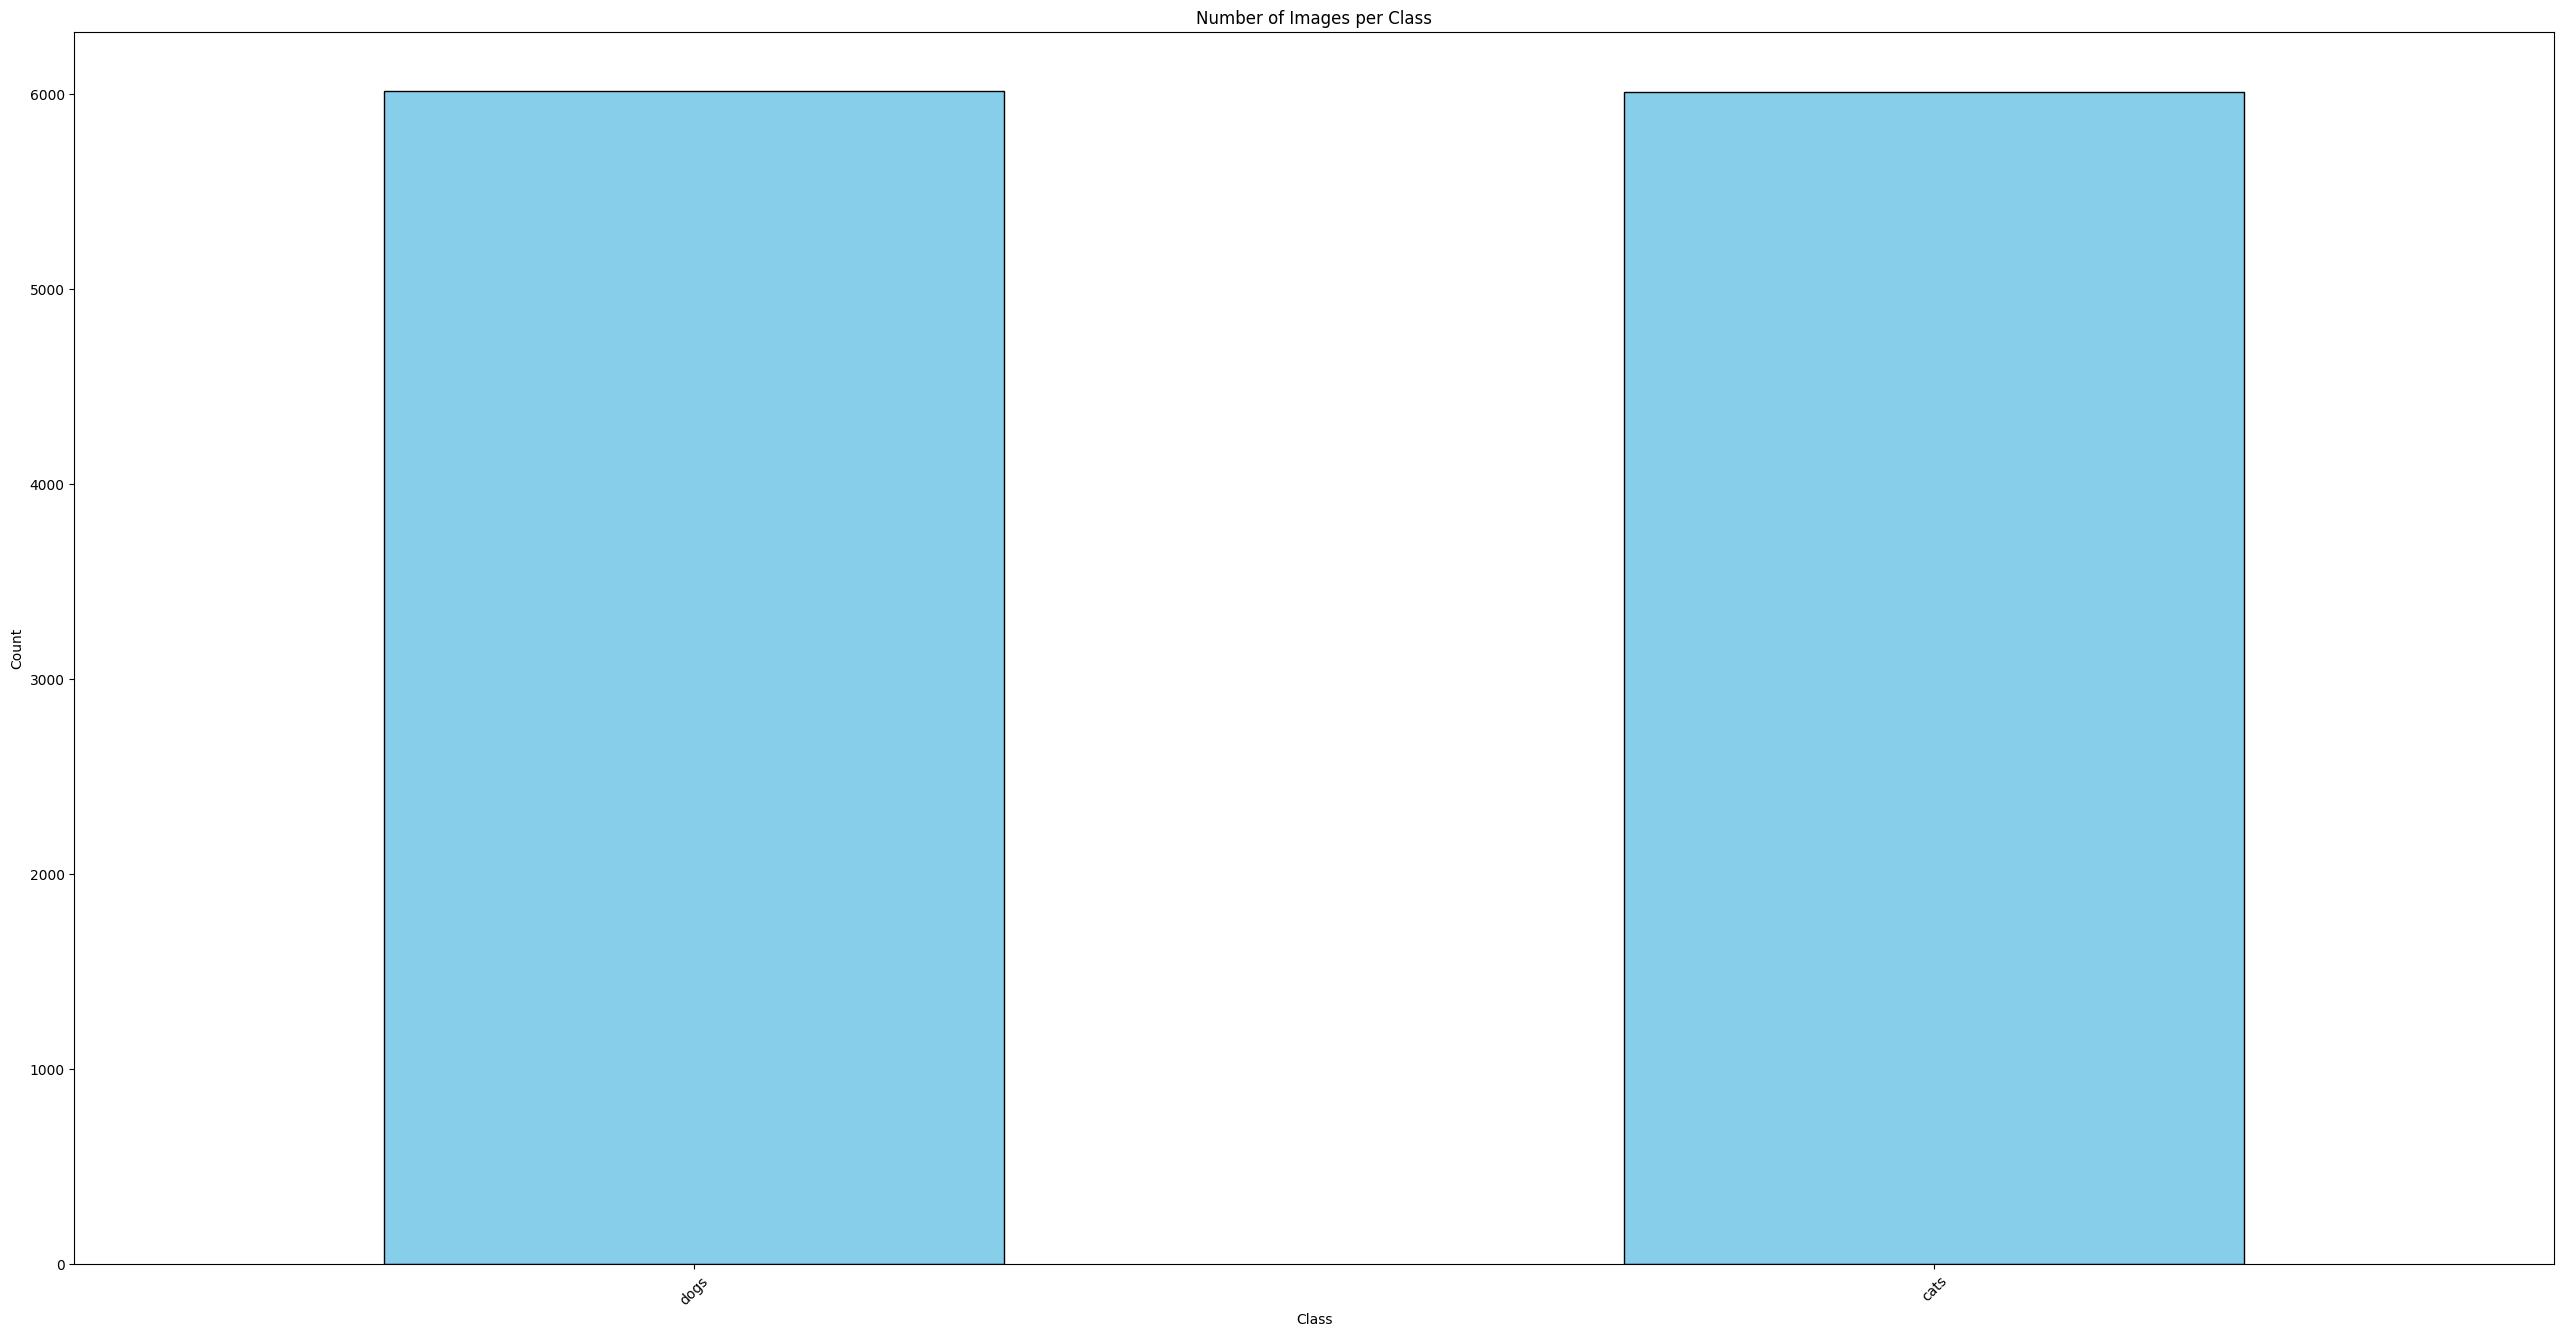

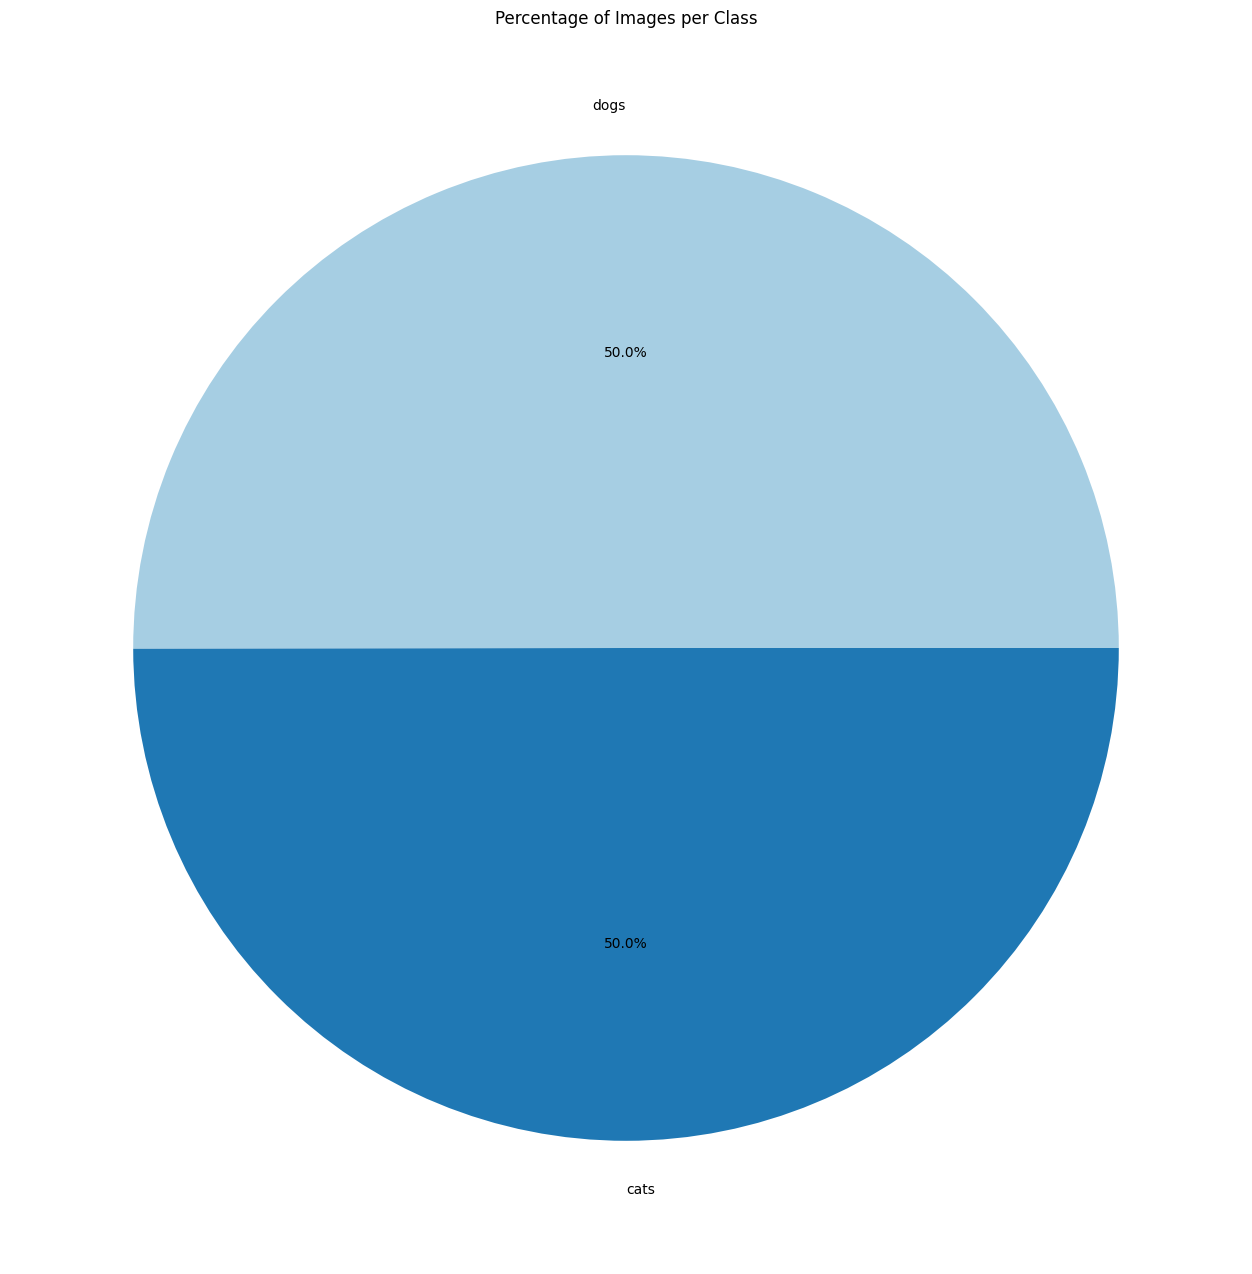

In [ ]:
plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'pie', autopct = '%1.1f%%', colors = plt.cm.Paired.colors)
plt.title('Percentage of Images per Class')
plt.ylabel('')
plt.show()

       Count  Percentage %
class                     
dogs    6017         50.02
cats    6011         49.98


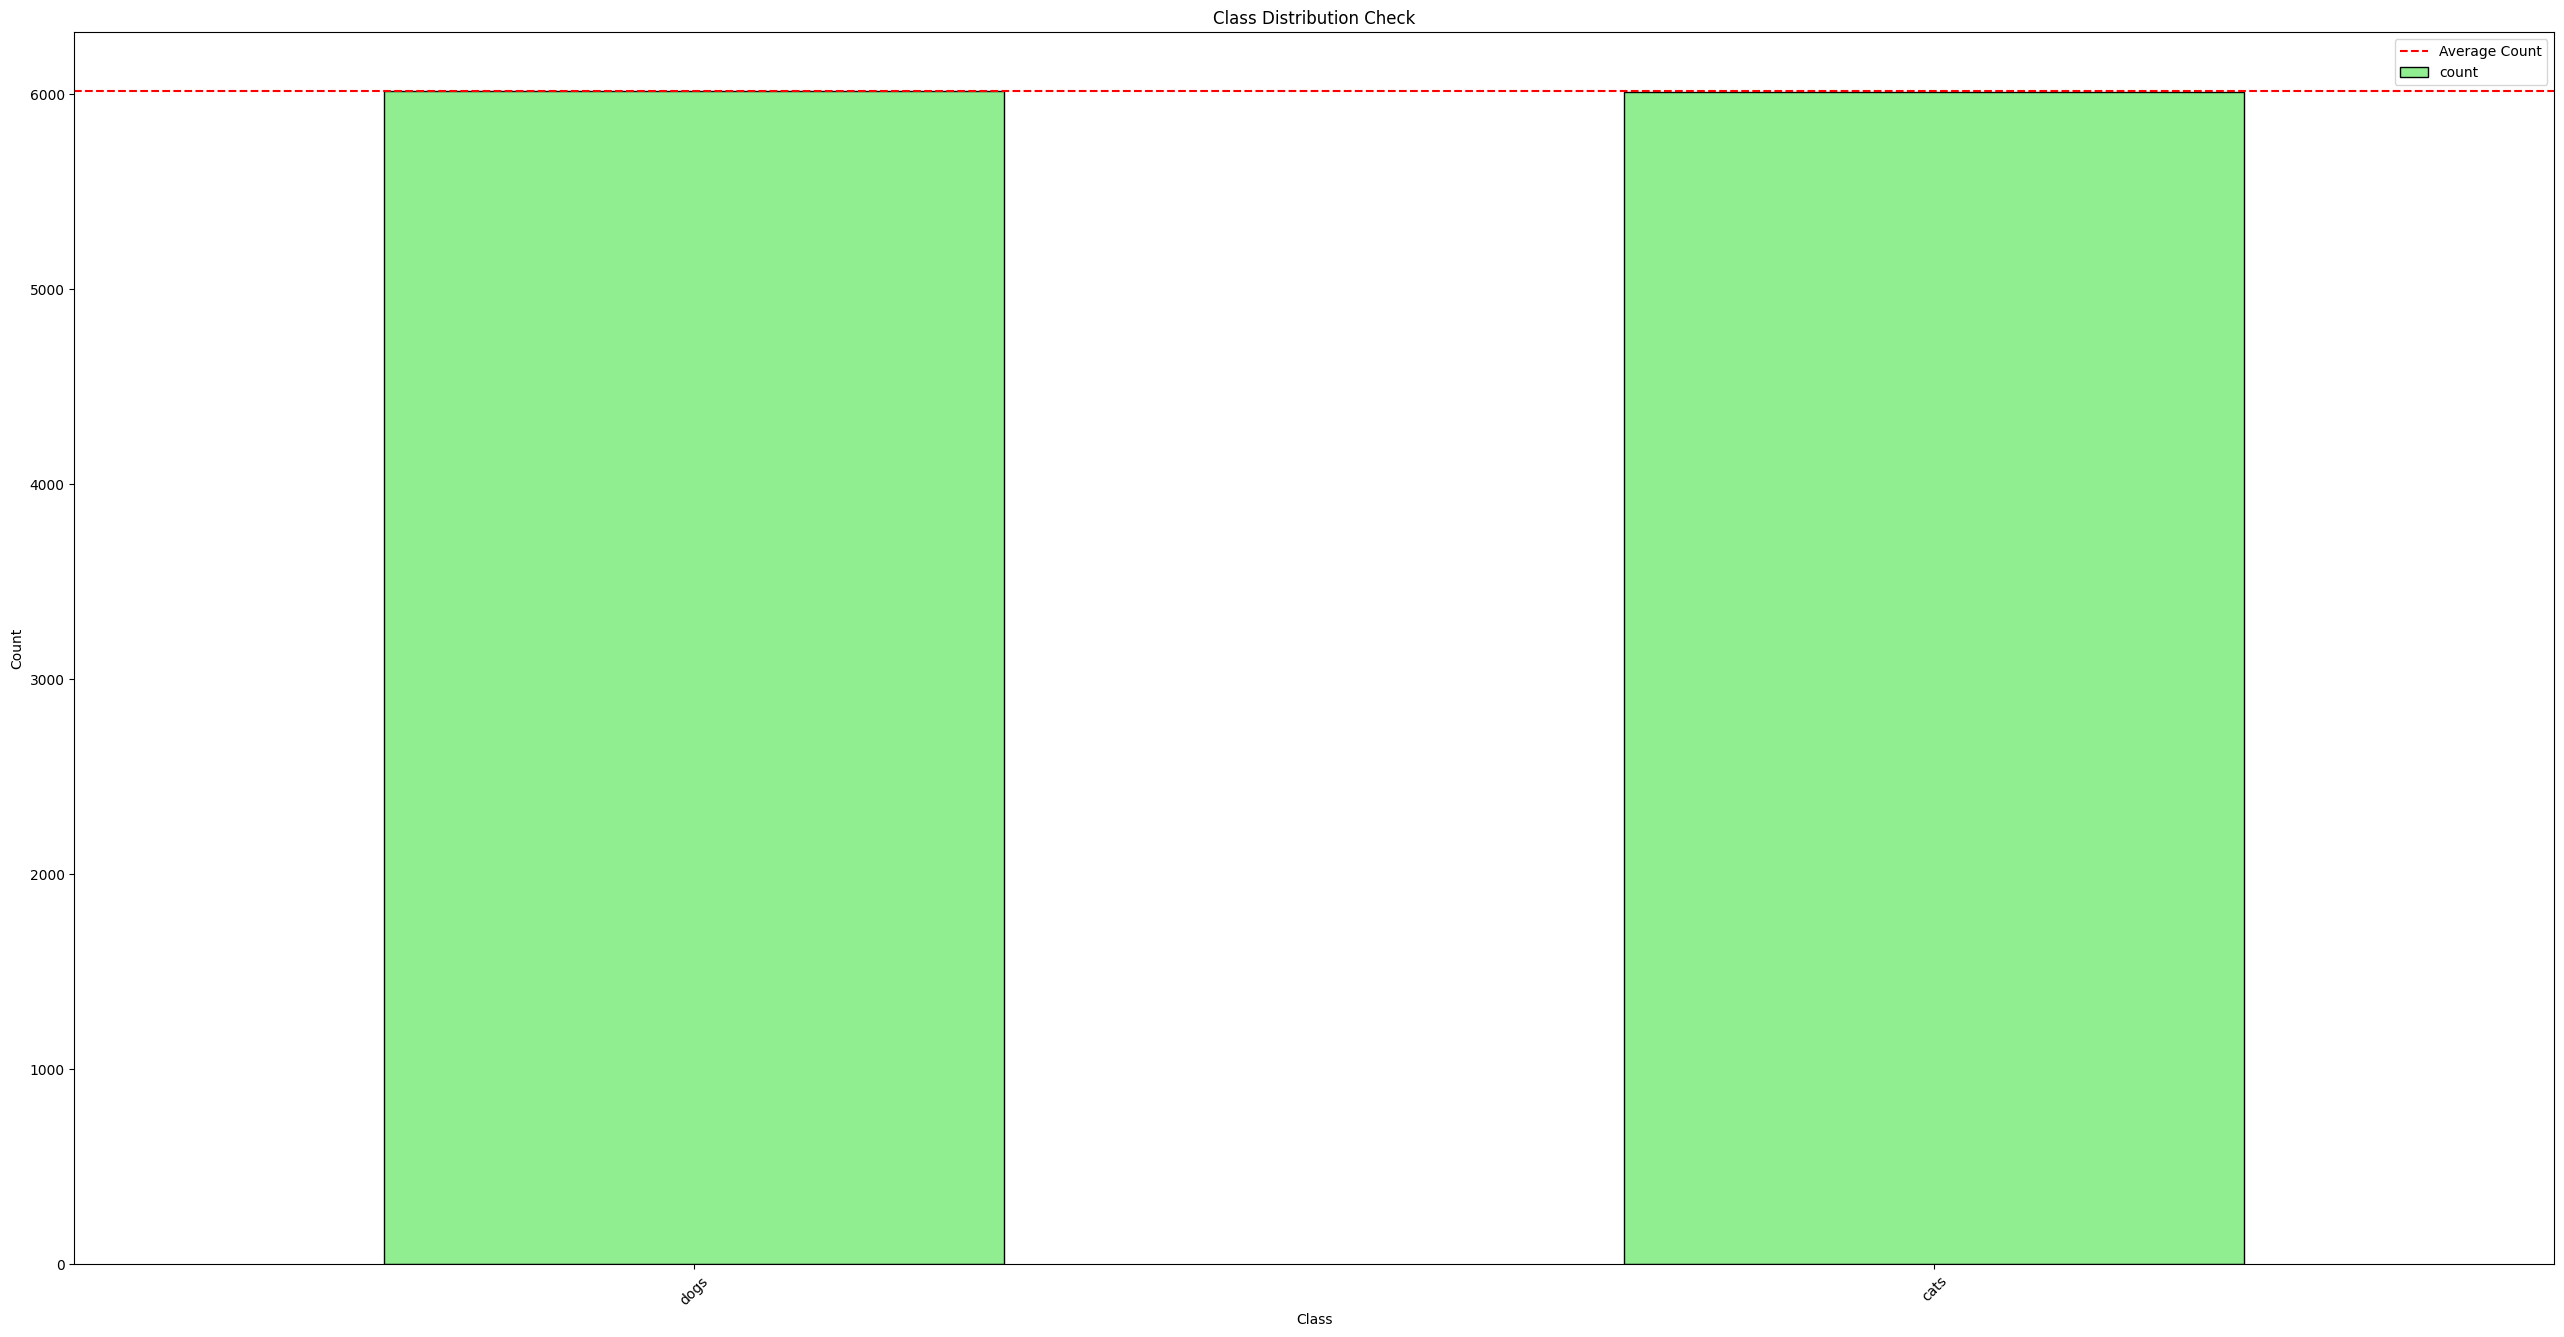

In [ ]:
percentages = (class_count / len(df)) * 100
imbalance_df = pd.DataFrame({'Count': class_count, 'Percentage %': percentages.round(2)})
print(imbalance_df)

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Class Distribution Check')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.axhline(y = class_count.mean(), color = 'red', linestyle = '--', label = 'Average Count')
plt.legend()
plt.show()

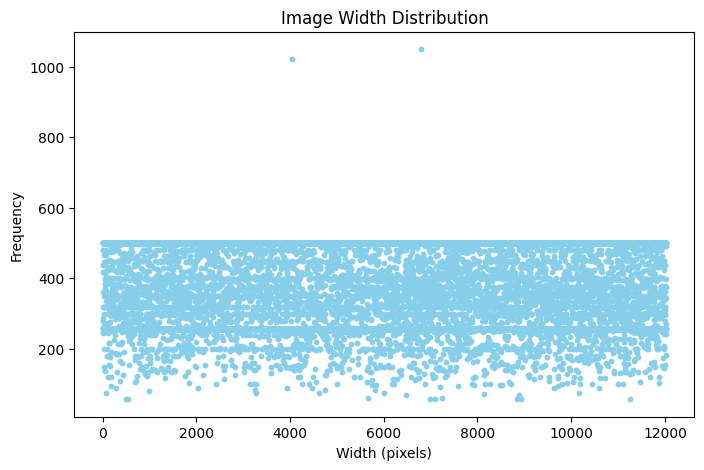

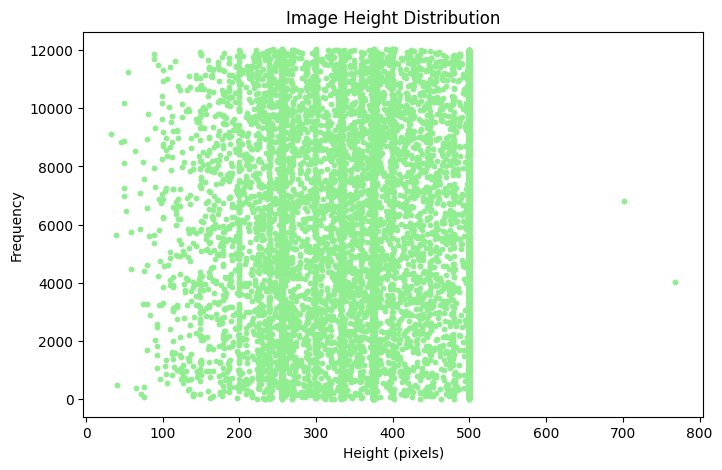

      Width  Height  Count
0       256     256   2000
1       500     374   1185
2       499     375   1165
3       375     499    106
4       499     333     99
...     ...     ...    ...
4192    319     209      1
4193    319     215      1
4194    319     220      1
4195    319     223      1
4196    319     309      1

[4197 rows x 3 columns]
Image Mode Distribution:
Mode
RGB    12028
Name: count, dtype: int64

Number of Channels Distribution:
Channels
3    12028
Name: count, dtype: int64


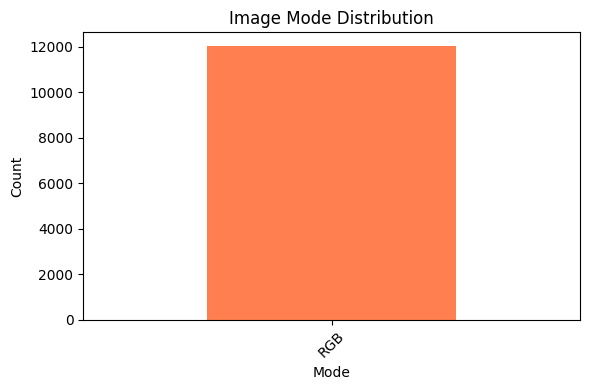

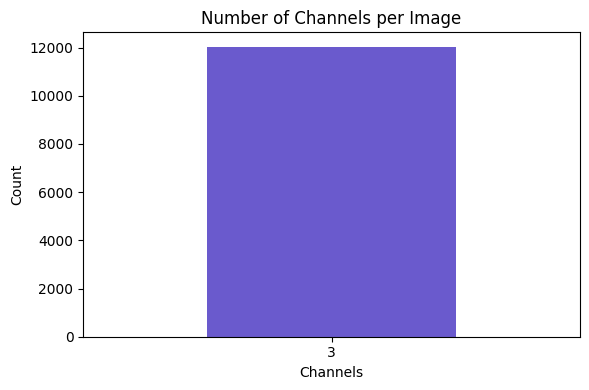

In [ ]:
image_sizes = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

#Width
plt.figure(figsize=(8,5))
plt.scatter(x = range(len(sizes_df)), y = sizes_df['Width'], color='skyblue', s=10)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

#Height
plt.figure(figsize=(8,5))
plt.scatter(x = sizes_df['Height'], y = range(len(sizes_df)), color='lightgreen', s=10)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

#For best sure the size of the whole images
unique_sizes = sizes_df.value_counts().reset_index(name='Count')
print(unique_sizes)

image_data = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        width, height = img.size
        mode = img.mode  # e.g., 'RGB', 'L', 'RGBA', etc.
        channels = len(img.getbands())  # Number of channels
        image_data.append((width, height, mode, channels))

# Create DataFrame
image_df = pd.DataFrame(image_data, columns=['Width', 'Height', 'Mode', 'Channels'])

print("Image Mode Distribution:")
print(image_df['Mode'].value_counts())

print("\nNumber of Channels Distribution:")
print(image_df['Channels'].value_counts())

plt.figure(figsize=(6,4))
image_df['Mode'].value_counts().plot(kind='bar', color='coral')
plt.title("Image Mode Distribution")
plt.xlabel("Mode")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
image_df['Channels'].value_counts().sort_index().plot(kind='bar', color='slateblue')
plt.title("Number of Channels per Image")
plt.xlabel("Channels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Image: cat.2559.jpg | Class: cats | Size: 499x357 | Brightness: 111.9 | Contrast: 64.5
Image: 1_0250.jpg | Class: dogs | Size: 256x256 | Brightness: 114.1 | Contrast: 57.5
Image: cat.2451.jpg | Class: cats | Size: 334x400 | Brightness: 131.5 | Contrast: 39.1
Image: ___cat.4807.jpg | Class: cats | Size: 500x373 | Brightness: 65.6 | Contrast: 53.9
Image: 0_0065.jpg | Class: cats | Size: 256x256 | Brightness: 155.8 | Contrast: 48.5
Image: dog.1578.jpg | Class: dogs | Size: 499x334 | Brightness: 105.4 | Contrast: 58.4
Image: ___cat.4530.jpg | Class: cats | Size: 499x375 | Brightness: 143.3 | Contrast: 57.4
Image: cat.1302.jpg | Class: cats | Size: 499x375 | Brightness: 95.4 | Contrast: 36.4
Image: dog.2137.jpg | Class: dogs | Size: 410x500 | Brightness: 124.5 | Contrast: 46.8
Image: dog.2535.jpg | Class: dogs | Size: 375x499 | Brightness: 108.4 | Contrast: 65.1


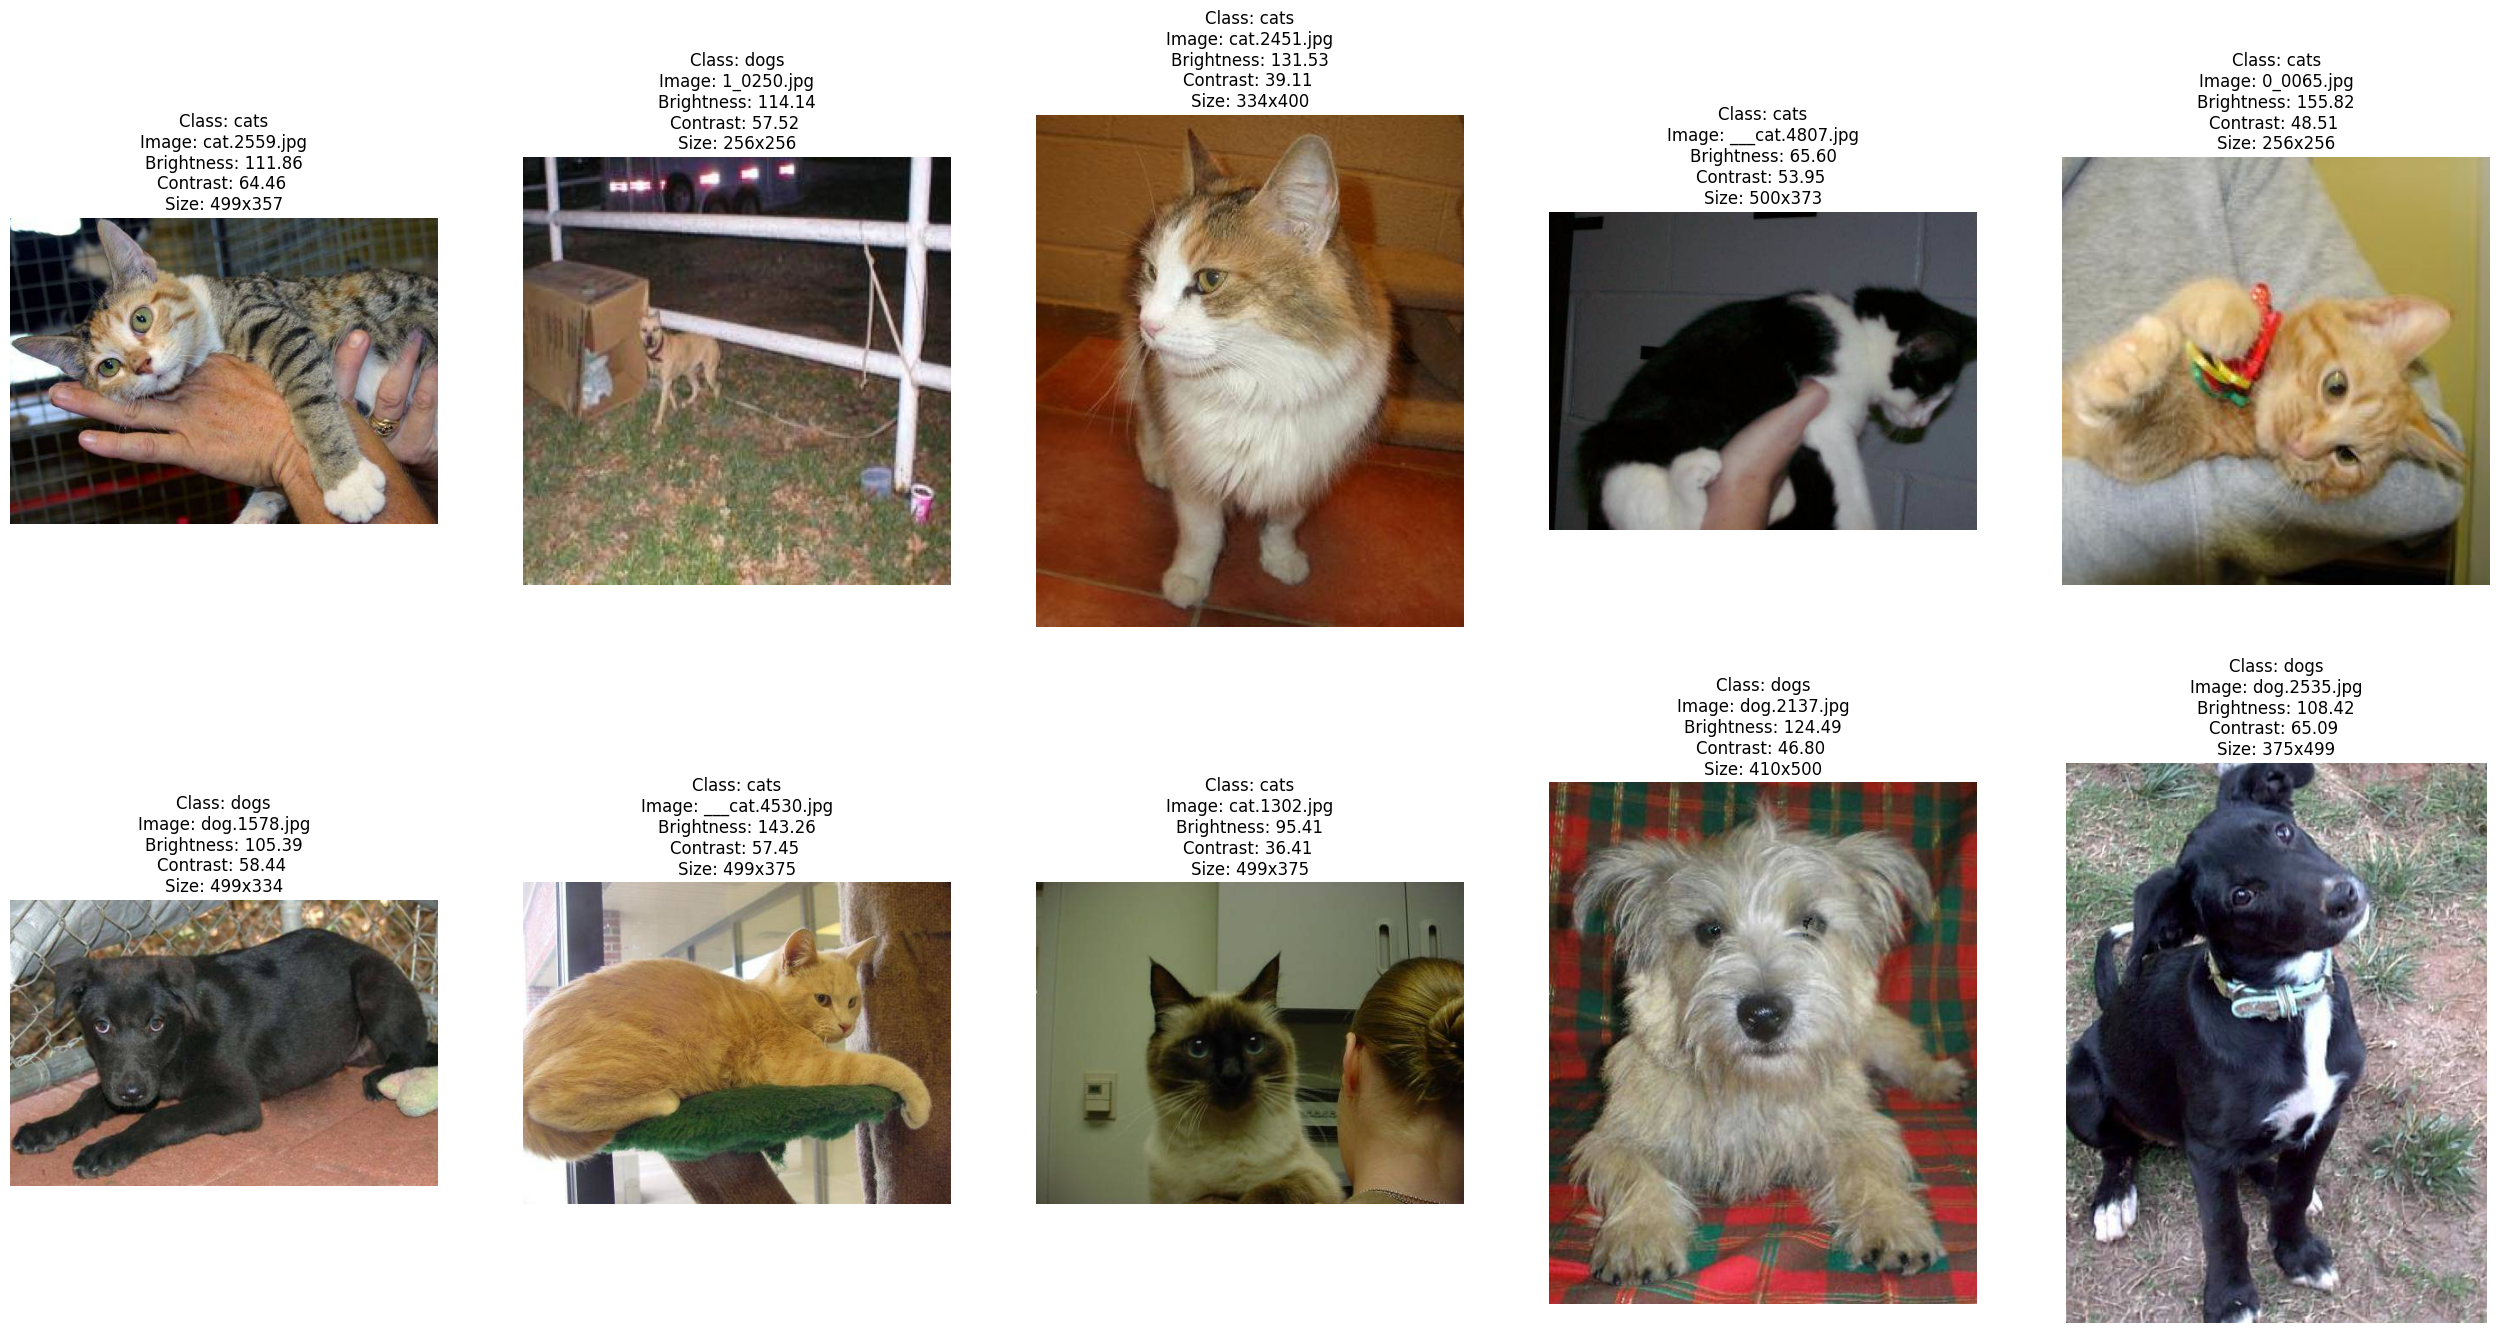

In [ ]:
sample_df = df.sample(n = 10, random_state = 42)

plt.figure(figsize=(32, 16))

for i, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
      stat = ImageStat.Stat(img.convert("RGB")) #Convert images to RGB images
      brightness = stat.mean[0]
      contrast = stat.stddev[0]

      width, height = img.size
      # Print size to console
      print(f"Image: {img_name} | Class: {cls} | Size: {width}x{height} | Brightness: {brightness:.1f} | Contrast: {contrast:.1f}")

      plt.subplot(2, 5, i + 1)
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Class: {cls}\nImage: {img_name}\nBrightness: {brightness:.2f}\nContrast: {contrast:.2f} \nSize: {width}x{height}")

plt.tight_layout
plt.show()

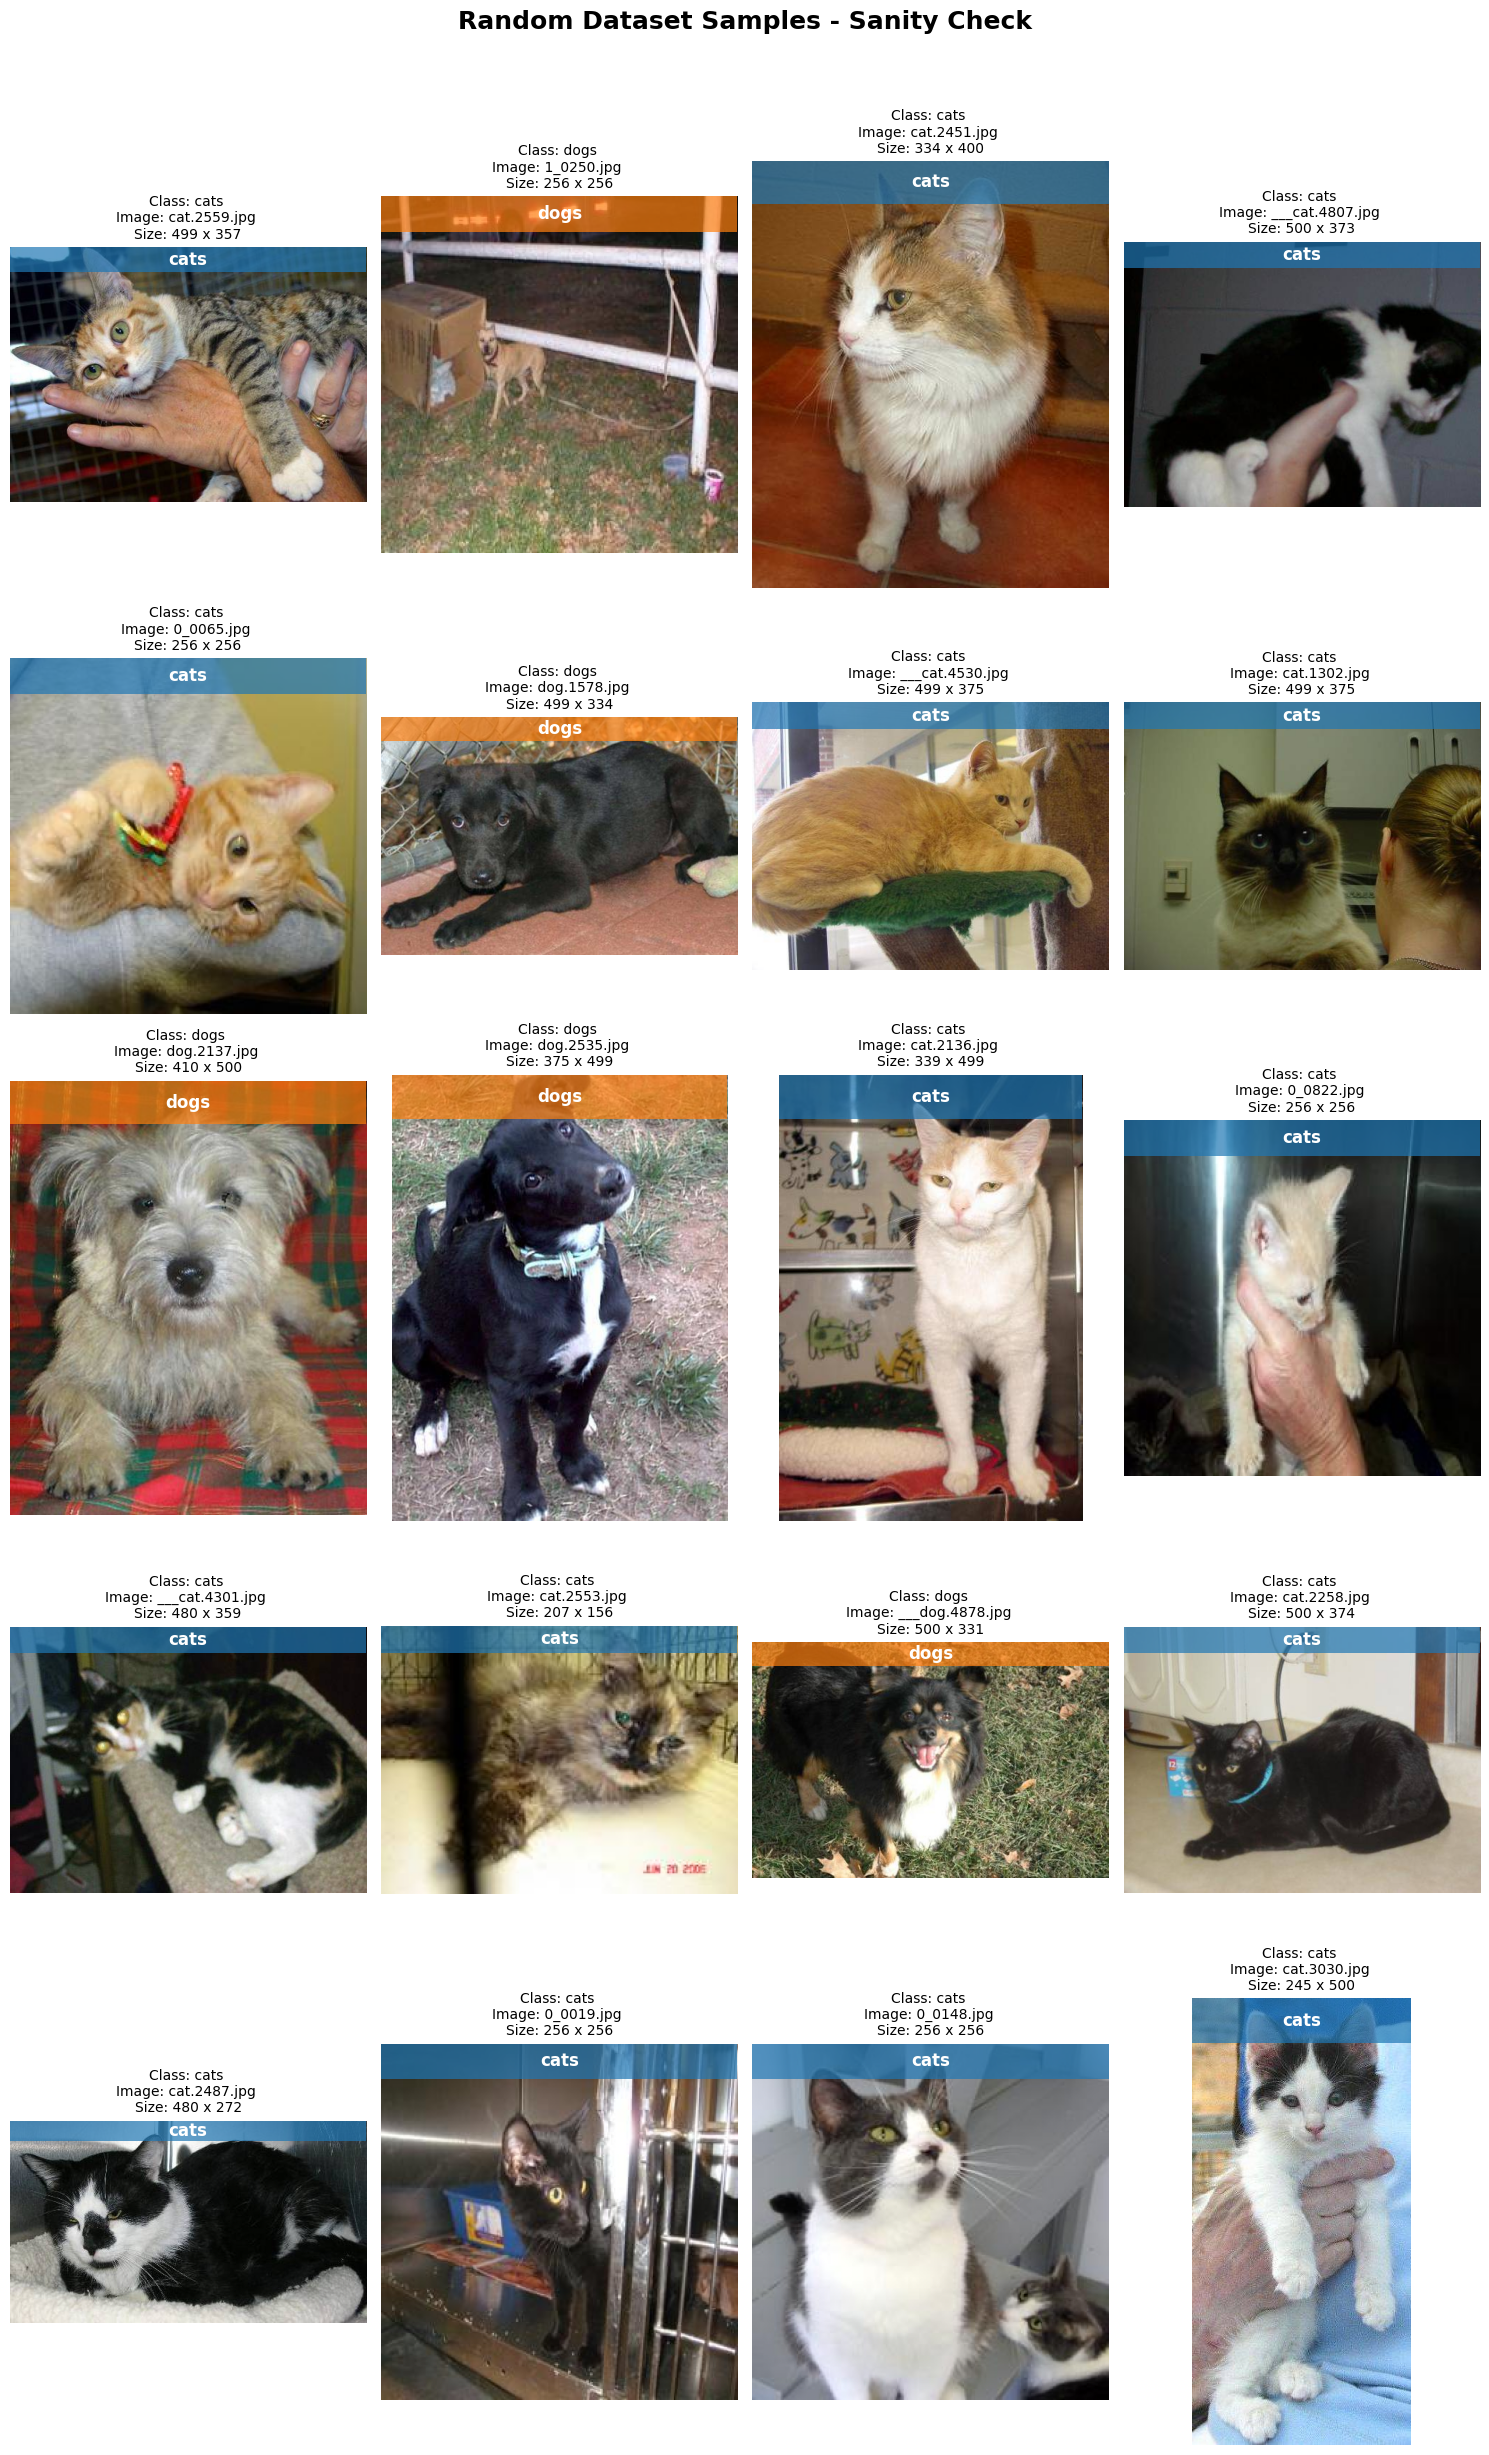

In [ ]:
# Sample 20 random images
num_samples = 20
sample_df = df.sample(num_samples, random_state=42)

# Get sorted class list and color map
classes = sorted(df['class'].unique())
colors = plt.cm.tab10.colors

# Grid setup
cols = 4
rows = num_samples // cols + int(num_samples % cols > 0)

# Figure setup
plt.figure(figsize=(15, 5 * rows))

for idx, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(img)
        ax.axis('off')

        # Title with class info
        ax.set_title(
            f"Class: {cls} \nImage: {img_name} \nSize: {img.width} x {img.height}",
            fontsize=10
        )

        label_height = 0.1  # 10% of image height
        label_width = 1.0   # full width of the image

        rect = patches.Rectangle(
        (0, 1 - label_height), label_width, label_height,
        transform=ax.transAxes,
        linewidth=0,
        edgecolor=None,
        facecolor=colors[classes.index(cls) % len(colors)],
        alpha=0.7
      )
        ax.add_patch(rect)

        # Add class name text centered horizontally
        ax.text(
        0.5, 1 - label_height / 2,
        cls,
        transform=ax.transAxes,
        fontsize=12,
        color="white",
        fontweight="bold",
        va="center",
        ha="center"
      )

# Figure title and layout
plt.suptitle("Random Dataset Samples - Sanity Check", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Check missing files
print("Missing values per column: ")
print(df.isnull().sum())

#Check duplicate files
duplicate_names = df.duplicated().sum()
print(f"\nNumber of duplicate files: {duplicate_names}")

duplicate_names = df[df.duplicated(subset = ['image'], keep = False)]
print(f"Duplicate file names: {len(duplicate_names)}")

#Check if two images or more are the same even if they are having different file names
def get_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['file_hash'] = df['full_path'].apply(get_hash)
duplicate_hashes = df[df.duplicated(subset = ['file_hash'], keep = False)]
print(f"Duplicate image files: {len(duplicate_hashes)}")

#This code below just removing the duplicate files, which means will not be feeded to the model, but will be still in the actual directory
#Important note: duplicates are removed from the dataframe only, not from the actual directory.
#Drop duplicates based on file_hash, keeping the first one

# df_unique = df.drop_duplicates(subset='file_hash', keep='first')
# print(f"After removing duplicates, unique images: {len(df_unique)}")

#Check for images extentions
df['extenstion'] = df['image'].apply(lambda x: Path(x).suffix.lower())
print("File type counts: ")
#print(df['extenstion'].value_counts)
print(df['extenstion'].value_counts())

#Check for resolution relationships
df['Width'] = sizes_df['Width']
df['Height'] = sizes_df['Height']
#print(df.groupby(['Width', 'Height']).size())
print(df.groupby('class')[['Width', 'Height']].agg(['min', 'max', 'mean']))

#Check for class balance (relationship between label and count)
class_summary = df['class'].value_counts(normalize = False).to_frame('Count')
#class_summary['Percentage'] = class_summary['Count'] / class_summary['Count'].sum() * 100
#class_summary
class_summary['Percentage %'] = round((class_summary['Count'] / len(df)) * 100, 2)
print(class_summary)

Missing values per column: 
class        0
image        0
full_path    0
dtype: int64

Number of duplicate files: 0
Duplicate file names: 0
Duplicate image files: 60
File type counts: 
extenstion
.jpg    12028
Name: count, dtype: int64
      Width                   Height                 
        min   max        mean    min  max        mean
class                                                
cats     59  1023  384.575611     39  768  339.475794
dogs     57  1050  374.206249     33  702  346.780622
       Count  Percentage %
class                     
dogs    6017         50.02
cats    6011         49.98


# **Data Cleaning**

In [ ]:
# Check corrupted files
corrupted_files = []

for file_path in df['full_path']:
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify file integrity
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(file_path)

print(f"Found {len(corrupted_files)} corrupted images.")

if corrupted_files:
    df = df[~df['full_path'].isin(corrupted_files)].reset_index(drop=True)
    print("Corrupted files removed.")


# Outliers detection (resolution-based)
width_mean = sizes_df['Width'].mean()
width_std = sizes_df['Width'].std()
height_mean = sizes_df['Height'].mean()
height_std = sizes_df['Height'].std()

outliers = df[
    (df['Width'] > width_mean + 3 * width_std) |
    (df['Width'] < width_mean - 3 * width_std) |
    (df['Height'] > height_mean + 3 * height_std) |
    (df['Height'] < height_mean - 3 * height_std)
]
print(f"Found {len(outliers)} resolution outliers.")

# Brightness / Contrast check (without storing images)
too_dark = []
too_bright = []
blank_or_gray = []

# Thresholds
dark_threshold = 30    # Below this is too dark
bright_threshold = 225 # Above this is too bright
low_contrast_threshold = 5  # Low contrast ~ blank/gray

for idx, file_path in enumerate(df['full_path']):
    try:
        with Image.open(file_path).convert('RGB') as img:
            gray = img.convert('L')
            stat = ImageStat.Stat(gray)
            brightness = stat.mean[0]
            contrast = stat.stddev[0]

            if brightness < dark_threshold:
                too_dark.append(file_path)
            elif brightness > bright_threshold:
                too_bright.append(file_path)
            elif contrast < low_contrast_threshold:
                blank_or_gray.append(file_path)
    except Exception as e:
        print(f"Skipping {file_path} due to error: {e}")

print(f"Too dark images: {len(too_dark)}")
print(f"Too bright images: {len(too_bright)}")
print(f"Blank/gray images: {len(blank_or_gray)}")

# (Optional) Drop too bright / blank-gray images
# df = df[~df['full_path'].isin(too_bright + blank_or_gray)].reset_index(drop=True)

# Note: No in-memory enhancement here.
# Enhancements (brightness/contrast adjustments) will be moved into `tf.data` pipeline.

Found 0 corrupted images.
Found 12 resolution outliers.
Too dark images: 4
Too bright images: 6
Blank/gray images: 0


In [ ]:
# Point to the extracted dataset, not the zip file location
dataset_root = "/content/my_data/Cats_and_Dogs_V2"

# Check mislabeled images
mismatches = []
for i, row in df.iterrows():
    folder_name = os.path.basename(os.path.dirname(row["full_path"]))
    if row["class"] != folder_name:
        mismatches.append((row["full_path"], row["class"], folder_name))

print(f"Found {len(mismatches)} mislabeled images (class vs folder mismatch).")

# Compare classes vs folders
classes_in_df = set(df["class"].unique())
folders_in_fs = {f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))}

print("Classes in DF but not in folders:", classes_in_df - folders_in_fs)
print("Folders in FS but not in DF:", folders_in_fs - classes_in_df)

Found 0 mislabeled images (class vs folder mismatch).
Classes in DF but not in folders: set()
Folders in FS but not in DF: set()


In [ ]:
def check_file_naming_issues(df):
    issues = {"invalid_chars": [], "spaces": [], "long_paths": [], "case_conflicts": [], "duplicate_names_across_classes": []}

    seen_names = {}

    for _, row in df.iterrows():
        fpath = row["full_path"]              # full path
        fname = os.path.basename(fpath)       # just filename
        cls = row["class"]

        # Invalid characters
        if re.search(r'[<>:"/\\|?*]', fname):  # Windows restricted chars
            issues["invalid_chars"].append(fpath)

        # Spaces
        if "  " in fname or fname.startswith(" ") or fname.endswith(" "):
            issues["spaces"].append(fpath)

        # Long paths
        if len(fpath) > 255:
            issues["long_paths"].append(fpath)

        # Case conflicts
        lower_name = fname.lower()
        if lower_name in seen_names and seen_names[lower_name] != cls:
            issues["case_conflicts"].append((fpath, seen_names[lower_name]))
        else:
            seen_names[lower_name] = cls

    # Duplicate names across classes
    duplicates = df.groupby(df["full_path"].apply(os.path.basename))["class"].nunique()
    duplicates = duplicates[duplicates > 1].index.tolist()
    for dup in duplicates:
        dup_paths = df[df["full_path"].str.endswith(dup)]["full_path"].tolist()
        issues["duplicate_names_across_classes"].extend(dup_paths)

    return issues

# Run the check
naming_issues = check_file_naming_issues(df)

for issue_type, files in naming_issues.items():
    print(f"\n{issue_type.upper()} ({len(files)})")
    for f in files[:10]:  # preview first 10
        print(f)


INVALID_CHARS (0)

SPACES (0)

LONG_PATHS (0)

CASE_CONFLICTS (0)

DUPLICATE_NAMES_ACROSS_CLASSES (0)


# **Data Preprocessing**

In [ ]:
# Build lookup tables for dark/bright flags
dark_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(too_dark),
        values=tf.constant([1] * len(too_dark), dtype=tf.int32)
    ),
    default_value=0
)

bright_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(too_bright),
        values=tf.constant([1] * len(too_bright), dtype=tf.int32)
    ),
    default_value=0
)

def preprocess_image(path, target_size=(256, 256), augment=True):
    # Decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Check if path is in too_dark / too_bright lists
    is_dark = dark_table.lookup(path)
    is_bright = bright_table.lookup(path)

    # Enhance dark images (increase brightness & contrast)
    img = tf.cond(
        tf.equal(is_dark, 1),
        lambda: tf.image.adjust_brightness(img, 0.2),   # brighten
        lambda: img
    )
    img = tf.cond(
        tf.equal(is_dark, 1),
        lambda: tf.image.adjust_contrast(img, 1.5),     # boost contrast
        lambda: img
    )

    # Reduce brightness for too bright images
    img = tf.cond(
        tf.equal(is_bright, 1),
        lambda: tf.image.adjust_brightness(img, -0.2),  # darken
        lambda: img
    )
    img = tf.cond(
        tf.equal(is_bright, 1),
        lambda: tf.image.adjust_contrast(img, 1.2),     # slight contrast boost
        lambda: img
    )

    if augment:                                   # if augment and tf.random.uniform(()) < 0.1: --> Use this if you want to apply 10% of your images per epoch
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

# Or this too:

# if augment:
#     if tf.random.uniform(()) < 0.1:
#         img = tf.image.random_flip_left_right(img)
#     if tf.random.uniform(()) < 0.1:
#         img = tf.image.random_flip_up_down(img)
#     if tf.random.uniform(()) < 0.2:
#         img = tf.image.random_brightness(img, max_delta=0.1)
#     if tf.random.uniform(()) < 0.2:
#         img = tf.image.random_contrast(img, 0.9, 1.1)

In [ ]:
# Encode class labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['class'])

print("Classes found:", le.classes_)
print(df[['class', 'label_encoded']].head())

Classes found: ['cats' 'dogs']
  class  label_encoded
0  cats              0
1  cats              0
2  cats              0
3  cats              0
4  cats              0


Dataset sizes:
Train: 9742 images
Validation: 1083 images
Test: 1203 images
--------------------------------------------------
Train labels sample: 6287     1
2819     0
11525    1
7073     1
8171     1
8388     1
5854     0
7677     1
1775     0
7896     1
Name: label_encoded, dtype: int64
Validation labels sample: 8557     1
3374     0
902      0
9119     1
4296     0
5022     0
781      0
10465    1
10683    1
309      0
Name: label_encoded, dtype: int64
Test labels sample: 8945     1
7009     1
8510     1
11634    1
3124     0
6633     1
10240    1
6983     1
4583     0
7830     1
Name: label_encoded, dtype: int64
Image dtype: <dtype: 'float32'>
Min pixel value: 0.0
Max pixel value: 1.0
Label: 0


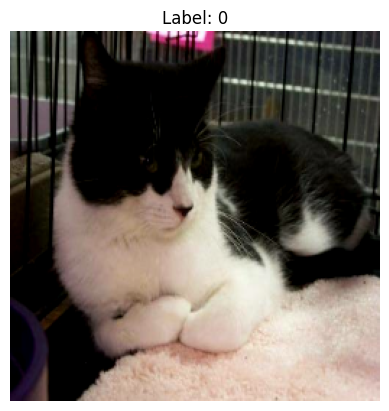

---------------------------------------------------
Number of Classes:  2


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

# Split data into train+val and test (10% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    df['full_path'], df['label_encoded'],
    test_size=0.1, random_state=42, stratify=df['label_encoded']
)

# Split train+val into train and val (10% of train_val as val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.1, random_state=42, stratify=train_val_labels
)

# Load + preprocess (no augmentation for val/test)
def load_and_preprocess(path, label):
    return preprocess_image(path, augment=False), label

# Train dataset (with augmentation)
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_paths))  # shuffle paths+labels
train_ds = train_ds.map(lambda x, y: (preprocess_image(x, augment=True), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)

# Validation dataset (no augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

# Test dataset (no augmentation)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

# Debugging & sanity checks
print("Dataset sizes:")
print(f"Train: {len(train_paths)} images")
print(f"Validation: {len(val_paths)} images")
print(f"Test: {len(test_paths)} images")
print("--------------------------------------------------")
print("Train labels sample:", train_labels[:10])
print("Validation labels sample:", val_labels[:10])
print("Test labels sample:", test_labels[:10])

# Preview normalized image stats and visualization
for image_batch, label_batch in train_ds.take(1):
    image = image_batch[0]
    label = label_batch[0]
    print("Image dtype:", image.dtype)
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Label:", label.numpy())

    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

print("---------------------------------------------------")
print("Number of Classes: ", len(le.classes_))

In [ ]:
all_mins, all_maxs = [], []

for image_batch, _ in train_ds:  # goes through the entire dataset
    all_mins.append(np.min(image_batch.numpy()))
    all_maxs.append(np.max(image_batch.numpy()))

print("Global min pixel value:", np.min(all_mins))
print("Global max pixel value:", np.max(all_maxs))

Global min pixel value: 0.0
Global max pixel value: 1.0


In [ ]:
# After train_ds is defined
for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)  # full batch shape
    print("Label batch shape:", label_batch.shape)  # labels shape

    input_shape = image_batch.shape[1:]  # shape of a single image
    print("Single image shape:", input_shape)
    break

Image batch shape: (16, 256, 256, 3)
Label batch shape: (16,)
Single image shape: (256, 256, 3)


# **Model Loading**

In [ ]:
inception = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

# Number of classes
print("Number of Classes: ", len(le.classes_))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Number of Classes:  2


In [ ]:
x = GlobalAveragePooling2D()(inception.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x) # "sigmoid" for two classes

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy', # Two classes
  optimizer='adam',
  metrics=['accuracy']
)

# **Model Feature Extraction**

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True,  verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss',  verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks, verbose = 1)

Epoch 1/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9108 - loss: 0.2507
Epoch 1: val_loss improved from inf to 0.02959, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 73s 90ms/step - accuracy: 0.9108 - loss: 0.2506 - val_accuracy: 0.9898 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9526 - loss: 0.1169
Epoch 2: val_loss did not improve from 0.02959

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
609/609 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9526 - loss: 0.1169 - val_accuracy: 0.9834 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 3/5
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9564 - loss: 0.1115
Epoch 3: val_loss did not improve from 0.02959

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
609/609 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9564 - loss: 0.1115 - val_accuracy: 0.9898 - val_loss: 0.0296 - learning_rate: 5.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


# **Model Fine-Tuning**

In [ ]:
#Fine Tuning
for layer in inception.layers[-30:]: # Unfreeze last 30 layers (tune as needed)
    layer.trainable = True

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy', # Two classes
  optimizer='adam',
  metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,  verbose = 1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss',  verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks, verbose = 1)

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9424 - loss: 0.1752
Epoch 1: val_loss improved from inf to 0.05007, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 78s 91ms/step - accuracy: 0.9424 - loss: 0.1752 - val_accuracy: 0.9806 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9690 - loss: 0.0843
Epoch 2: val_loss improved from 0.05007 to 0.02475, saving model to best_model.h5


609/609 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.9690 - loss: 0.0843 - val_accuracy: 0.9926 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 3/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9781 - loss: 0.0613
Epoch 3: val_loss did not improve from 0.02475
609/609 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9781 - loss: 0.0613 - val_accuracy: 0.9898 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9823 - loss: 0.0536
Epoch 4: val_loss did not improve from 0.02475
609/609 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9823 - loss: 0.0536 - val_accuracy: 0.9889 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 5/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9859 - loss: 0.0388
Epoch 5: val_loss did not improve from 0.02475

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
609/609 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9859 - loss: 0.0388 - val_accuracy:

# **Model Evaluation**

In [ ]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9941 - loss: 0.0194


[0.02038443647325039, 0.9933499693870544]

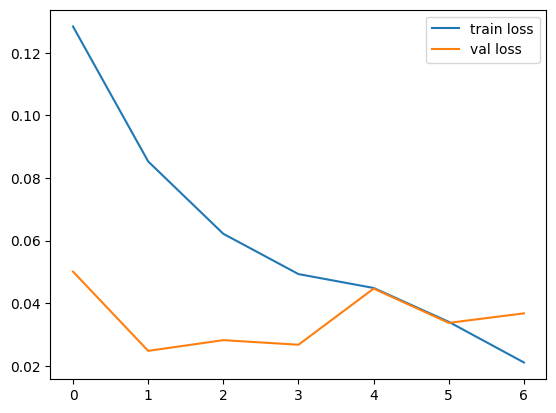

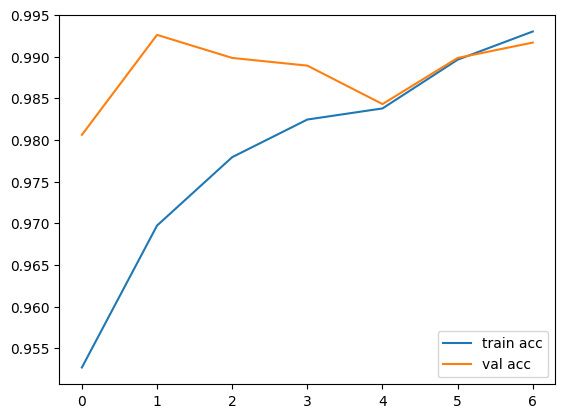

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (same order as test_ds batching)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# detailed report per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9941 - loss: 0.0194
Test Accuracy: 0.9933
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step
Precision: 0.2498, Recall: 0.5000, F1-score: 0.3331

Classification Report:
              precision    recall  f1-score   support

        cats       0.50      1.00      0.67       601
        dogs       0.00      0.00      0.00       602

    accuracy                           0.50      1203
   macro avg       0.25      0.50      0.33      1203
weighted avg       0.25      0.50      0.33      1203



76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9941 - loss: 0.0194
Test Accuracy: 0.9933
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99       601
        dogs       0.99      1.00      0.99       602

    accuracy                           0.99      1203
   macro avg       0.99      0.99      0.99      1203
weighted avg       0.99      0.99      0.99      1203



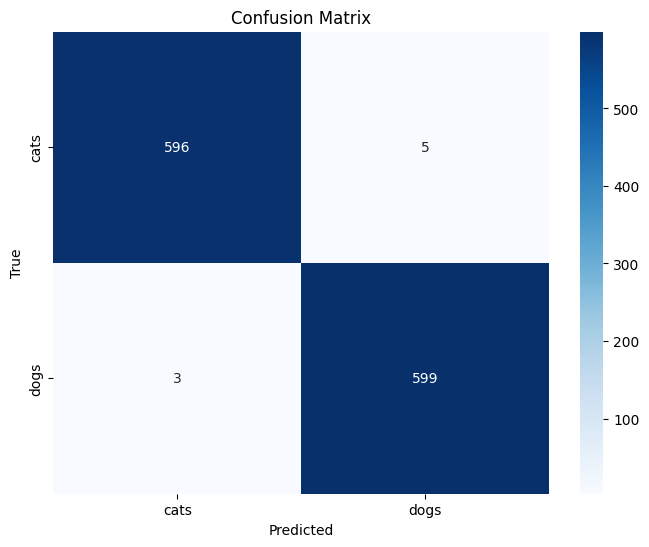

In [ ]:
# Number of classes
num_classes = len(le.classes_)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_probs = model.predict(test_ds)  # shape: (num_samples, num_classes)
# For 1-neuron sigmoid
y_pred = (y_probs > 0.5).astype(int).ravel()  # 0 = class 0, 1 = class 1

# True labels (extract from test_ds)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━

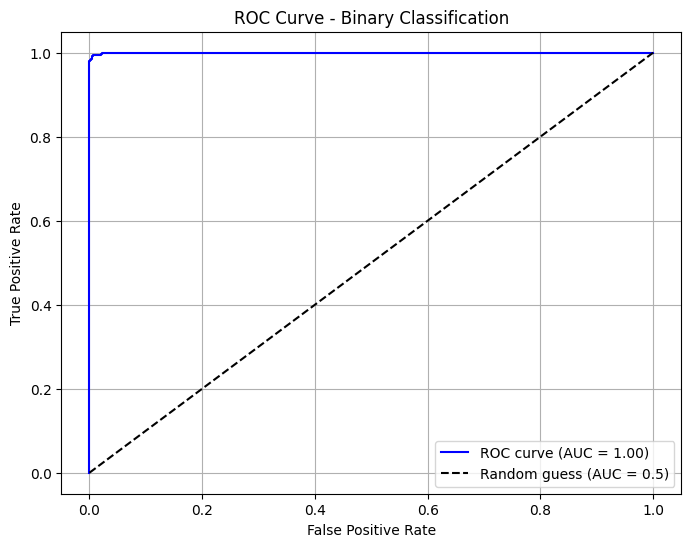

In [ ]:
# Get predicted probabilities and true labels
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images).flatten())  # flatten to get 1D array || To not print all these lines just use "model.predict(images, verbose=0)"

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUC = 0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
y_true_bin.shape: (1203, 2)
y_probs_all.shape: (1203, 2)


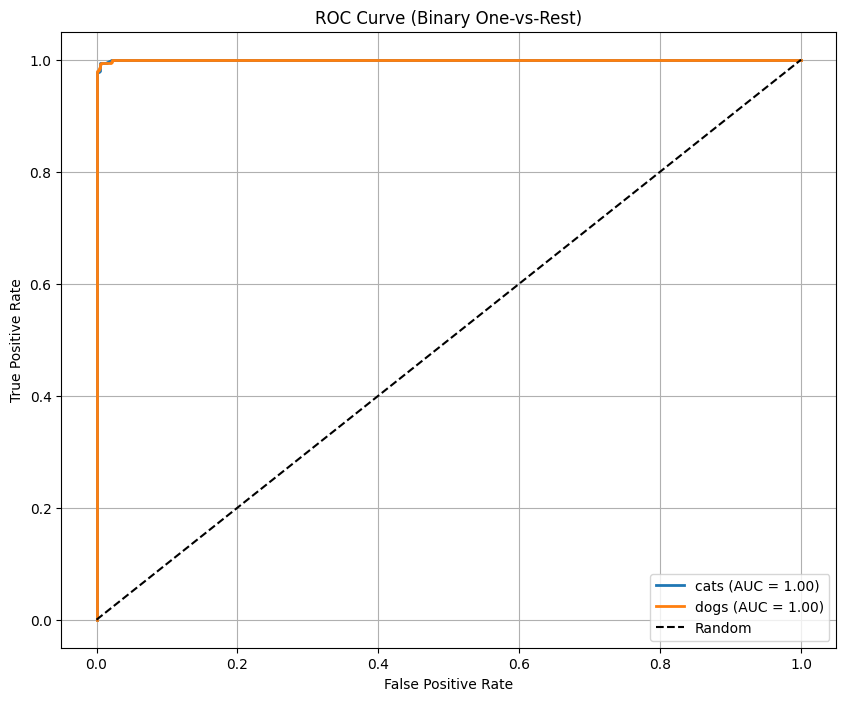

In [ ]:
# Binarize true labels for ROC with 2 classes
y_true_bin = label_binarize(y_true, classes=[0, 1])

# Force it to always be (N, 2) even if one class is missing in y_true
if y_true_bin.shape[1] == 1:
    y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

# Predict probabilities with sigmoid output
y_pred_probs = model.predict(test_ds).flatten()  # shape: (N,)

# Stack to get two columns for classes 0 and 1
y_probs_all = np.column_stack([1 - y_pred_probs, y_pred_probs])  # shape: (N, 2)

print("y_true_bin.shape:", y_true_bin.shape)
print("y_probs_all.shape:", y_probs_all.shape)

plt.figure(figsize=(10, 8))
for i in range(2):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# **Saving the Model**

In [ ]:
model.save("InceptionV3_Image_Classification.h5")
files.download("InceptionV3_Image_Classification.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>